## <div style="text-align: left; background-color: #003554; color: white; padding: 10px; line-height: 1">CS229 PROBLEM SET 1</div>
### <div style="text-align: left; background-color: #003554; color: white; padding: 10px; line-height: 1">PS1-1 Linear Classifiers (logistic regression and GDA)</div>

#### (a)
Recall the average empirical loss for logistic regression:
$$
J(\theta)=-\frac{1}{m} \sum_{i=1}^{m} y^{(i)} \log \left(h_{\theta}\left(x^{(i)}\right)\right)+\left(1-y^{(i)}\right) \log \left(1-h_{\theta}\left(x^{(i)}\right)\right)
$$


where $y^{(i)} \in\{0,1\}, h_{\theta}(x)=g\left(\theta^{T} x\right)$ and $g(z)=1 /\left(1+e^{-z}\right)$.
Compute the gradient of $J(\theta)$ :

$$
\begin{aligned}
\nabla_{\theta} J(\theta) &=-\frac{1}{m} \sum_{i=1}^{m} y^{(i)} \frac{1}{h_{\theta}\left(x^{(i)}\right)} h_{\theta}\left(x^{(i)}\right)\left(1-h_{\theta}\left(x^{(i)}\right)\right)-\left(1-y^{(i)}\right) \frac{1}{1-h_{\theta}\left(x^{(i)}\right)} h_{\theta}\left(x^{(i)}\right)\left(1-h_{\theta}\left(x^{(i)}\right)\right) \\
&=-\frac{1}{m} \sum_{i=1}^{m}\left(y^{(i)}-h_{\theta}\left(x^{(i)}\right)\right) x^{(i)}
\end{aligned}
$$

Then, the Hessian of $J(\theta)$ is:
$$
H=\nabla_{\theta}^{2} J(\theta)=\frac{1}{m} \sum_{i=1}^{m} h_{\theta}\left(x^{(i)}\right)\left(1-h_{\theta}\left(x^{(i)}\right)\right) x^{(i)}\left(x^{(i)}\right)^{T}
$$

And for any $z \in \mathbb{R}^{n}$ :
$$
\begin{aligned}
z^{T} H z &=\sum_{j=1}^{n} \sum_{k=1}^{n} H_{j k} z_{j} z_{k} \\
&=\sum_{j=1}^{n} \sum_{k=1}^{n} \frac{1}{m} \sum_{i=1}^{m} h_{\theta}\left(x^{(i)}\right)\left(1-h_{\theta}\left(x^{(i)}\right)\right) x_{j}^{(i)} x_{k}^{(i)} z_{j} z_{k} \\
&=\frac{1}{m} \sum_{i=1}^{m} h_{\theta}\left(x^{(i)}\right)\left(1-h_{\theta}\left(x^{(i)}\right)\right) \sum_{j=1}^{n} \sum_{k=1}^{n} z_{j} x_{j}^{(i)} x_{k}^{(i)} z_{k} \\
&=\frac{1}{m} \sum_{i=1}^{m} h_{\theta}\left(x^{(i)}\right)\left(1-h_{\theta}\left(x^{(i)}\right)\right)\left(\left(x^{(i)}\right)^{T} z\right)^{2} \\
& \geq 0
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import util as util
from linear_model import LinearModel

In [2]:
ds1_training_set_path = 'ds1_train.csv'
ds1_valid_set_path = 'ds1_valid.csv'
ds2_training_set_path = 'ds2_train.csv'
ds2_valid_set_path = 'ds2_valid.csv'

In [3]:
x_train, y_train = util.load_dataset(ds1_training_set_path, add_intercept=True)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path, add_intercept=True)

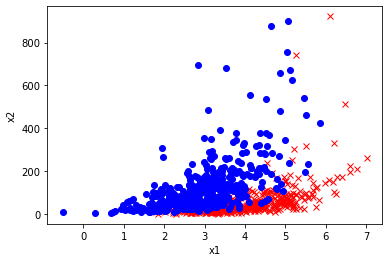

In [4]:
plt.xlabel('x1')
plt.ylabel('x2')
plt.plot(x_train[y_train == 1, -2], x_train[y_train == 1, -1], 'rx', linewidth=2)
plt.plot(x_train[y_train == 0, -2], x_train[y_train == 0, -1], 'bo', linewidth=2)

In [5]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """

        def h(theta, x):
            """Vectorized implementation of h_theta(x) = 1 / (1 + exp(-theta^T x)).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The hypothesis for all training examples. Shape (m,).
            """
            return 1 / (1 + np.exp(-np.dot(x, theta)))

        def gradient(theta, x, y):
            """Vectorized implementation of the gradient of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :param y:     All labels of shape (m,).
            :return:      The gradient of shape (n,).
            """
            m, _ = x.shape
            return -1 / m * np.dot(x.T, (y - h(theta, x)))

        def hessian(theta, x):
            """Vectorized implementation of the Hessian of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The Hessian of shape (n, n).
            """
            m, _ = x.shape
            h_theta_x = np.reshape(h(theta, x), (-1, 1))
            return 1 / m * np.dot(x.T, h_theta_x * (1 - h_theta_x) * x)

        def next_theta(theta, x, y):
            """The next theta updated by Newton's Method.

            :param theta: Shape (n,).
            :return:      The updated theta of shape (n,).
            """
            return theta - np.dot(np.linalg.inv(hessian(theta, x)), gradient(theta, x, y))

        m, n = x.shape

        # Initialize theta
        if self.theta is None:
            self.theta = np.zeros(n)

        # Update theta using Newton's Method
        old_theta = self.theta
        new_theta = next_theta(self.theta, x, y)
        while np.linalg.norm(new_theta - old_theta, 1) >= self.eps:
            old_theta = new_theta
            new_theta = next_theta(old_theta, x, y)

        self.theta = new_theta

    def predict(self, x):
        """Make a prediction given new inputs x.

        :param x: Inputs of shape (m, n).
        :return:  Outputs of shape (m,).
        """

        return x @ self.theta >= 0

In [6]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

Theta is:  [-6.26018491  2.47707251 -0.0299125 ]
The accuracy on training set is:  0.8825


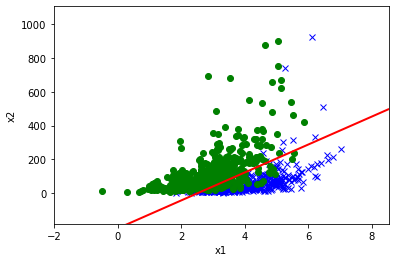

In [7]:
util.plot(x_train, y_train, theta=log_reg.theta)
print("Theta is: ", log_reg.theta)
print("The accuracy on training set is: ", np.mean(log_reg.predict(x_train) == y_train))

The accuracy on validation set is:  0.9


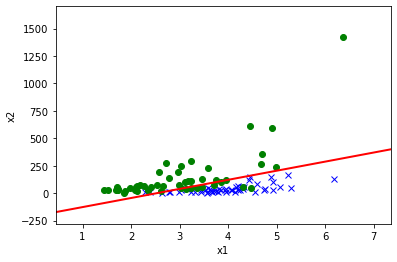

In [8]:
util.plot(x_valid, y_valid, log_reg.theta)
print("The accuracy on validation set is: ", np.mean(log_reg.predict(x_valid) == y_valid))

#### (c)
$$
\begin{aligned}
p\left(y=1 \mid x ; \phi, \mu_{0}, \mu_{1}, \Sigma\right) &=\frac{p\left(x \mid y=1 ; \mu_{0}, \mu_{1}, \Sigma\right) p(y=1 ; \phi)}{p\left(x \mid y=1 ; \mu_{0}, \mu_{1}, \Sigma\right) p(y=1 ; \phi)+p\left(x \mid y=0 ; \mu_{0}, \mu_{1}, \Sigma\right) p(y=0 ; \phi)} \\
&=1 /\left(1+\frac{p\left(x \mid y=0 ; \mu_{0}, \mu_{1}, \Sigma\right) p(y=0 ; \phi)}{p\left(x \mid y=1 ; \mu_{0}, \mu_{1}, \Sigma\right) p(y=1 ; \phi)}\right) \\
&=1 /\left(1+\exp \left(\frac{1}{2}\left(x-\mu_{1}\right)^{T} \Sigma^{-1}\left(x-\mu_{1}\right)-\frac{1}{2}\left(x-\mu_{0}\right)^{T} \Sigma^{-1}\left(x-\mu_{0}\right)\right) \frac{1-\phi}{\phi}\right) \\
&=1 /\left(1+\exp \left(-\left(\left(\mu_{1}-\mu_{0}\right)^{T} \Sigma^{-1} x+\left(\mu_{0}^{T} \Sigma^{-1} \mu_{0}-\mu_{1}^{T} \Sigma^{-1} \mu_{1}-\log \frac{1-\phi}{\phi}\right)\right)\right)\right) \\
&=1 /\left(1+\exp \left(-\left(\theta^{T} x+\theta_{0}\right)\right)\right)
\end{aligned}
$$

where $\theta=\Sigma^{-1}\left(\mu_{1}-\mu_{0}\right)$ and $\theta_{0}=\mu_{0}^{T} \Sigma^{-1} \mu_{0}-\mu_{1}^{T} \Sigma^{-1} \mu_{1}-\log \frac{1-\phi}{\phi}$.

#### (d)
To compute $\phi_{1} \mu_{0}$ and $\mu_{1}$, recall the log-likelihood:
$$
\begin{aligned}
\ell\left(\phi, \mu_{0}, \mu_{1}, \Sigma\right) &=\log \prod_{i=1}^{m} p\left(x^{(i)}, y^{(i)} ; \phi, \mu_{0}, \mu_{1}, \Sigma\right) \\
&=\log \prod_{i=1}^{m} p\left(x^{(i)} \mid y^{(i)} ; \mu_{0}, \mu_{1}, \Sigma\right) p\left(y^{(i)} ; \phi\right) \\
&=\log \prod_{i=1}^{m}\left(p\left(x^{(i)} \mid y^{(i)}=1 ; \mu_{0}, \mu_{1}, \Sigma\right) p\left(y^{(i)}=1 ; \phi\right)\right)^{1\left\{y^{(i)}=1\right\}}\left(p\left(x^{(i)} \mid y^{(i)}=0 ; \mu_{0}, \mu_{1}, \Sigma\right) p\left(y^{(i)}=0 ; \phi\right)\right)^{1\left\{y^{(i)}=0\right\}} \\
&=\sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\}\left(-\frac{1}{2}\left(x^{(i)}-\mu_{1}\right)^{T} \Sigma^{-1}\left(x^{(i)}-\mu_{1}\right)+\log \phi\right)+\sum_{i=1}^{m} 1\left\{y^{(i)}=0\right\}\left(-\frac{1}{2}\left(x^{(i)}-\mu_{0}\right)^{T} \Sigma^{-1}\left(x^{(i)}-\mu_{0}\right)+\log (1-\phi)\right)+C
\end{aligned}
$$

where $C$ does not contain $\phi, \mu_{0}$ or $\mu_{1}$.
Take derivative of $\ell$ w.r.t $\phi$ and set to 0 :

$$
\begin{aligned}
\frac{\partial}{\partial \phi} \ell\left(\phi, \mu_{0}, \mu_{1}, \Sigma\right) &=\sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\} \frac{1}{\phi}+\left(m-\sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\}\right) \frac{1}{1-\phi} \\
&=0
\end{aligned}
$$
We have $\phi=\frac{1}{m} \sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\}$.
Also, take derivative of $\ell$ w.r.t $\mu_{0}$ and set to 0 :

$$
\begin{aligned}
\frac{\partial}{\partial \mu_{0}} \ell\left(\phi, \mu_{0}, \mu_{1}, \Sigma\right) &=\sum_{i=1}^{m} 1\left\{y^{(i)}=0\right\} \Sigma^{-1}\left(x^{(i)}-\mu_{0}\right) \\
&=0
\end{aligned}
$$
We can easily obtain that 

$\mu_{0}=\sum_{i=1}^{m} 1\left\{y^{(i)}=0\right\} x^{(i)} / \sum_{i=1}^{m} 1\left\{y^{(i)}=0\right\}$. Similarly, $\mu_{1}=\sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\} x^{(i)} / \sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\}$.


To compute $\Sigma$, we need to simplify $\ell$ while maintaining $\Sigma$ :

$$
\begin{aligned}
\ell\left(\phi, \mu_{0}, \mu_{1}, \Sigma\right) &=\log \prod_{i=1}^{m} p\left(x^{(i)} \mid y^{(i)} ; \mu_{0}, \mu_{1}, \Sigma\right) p\left(y^{(i)} ; \phi\right) \\
&=-\frac{m}{2} \log |\Sigma|-\frac{1}{2} \sum_{i=1}^{m}\left(x^{(i)}-\mu_{y^{(i)}}\right)^{T} \Sigma^{-1}\left(x^{(i)}-\mu_{y^{(i)}}\right)+C \\
&=-\frac{m}{2} \log |\Sigma|-\frac{1}{2} \sum_{i=1}^{m} \operatorname{tr}\left(\left(x^{(i)}-\mu_{y^{(i)}}\right)^{T} \Sigma^{-1}\left(x^{(i)}-\mu_{y^{(i)}}\right)\right)+C \\
&=-\frac{m}{2} \log |\Sigma|-\frac{1}{2} \sum_{i=1}^{m} \operatorname{tr}\left(\Sigma^{-1}\left(x^{(i)}-\mu_{y^{(i)}}\right)\left(x^{(i)}-\mu_{y^{(i)}}\right)^{T}\right)+C
\end{aligned}
$$
Since $n=1$, i.e. $|\Sigma|=\sigma^{2}$, by taking derivative of $\ell$ w.r.t $\Sigma$ and set to 0 :

$$
\begin{aligned}
\frac{\partial}{\partial \Sigma} \ell\left(\phi, \mu_{0}, \mu_{1}, \Sigma\right) &=-\frac{m}{2 \Sigma}+\frac{1}{2} \sum_{i=1}^{m}\left(x^{(i)}-\mu_{y^{(i)}}\right)\left(x^{(i)}-\mu_{y^{(i)}}\right)^{T} \Sigma^{-2} \\
&=0
\end{aligned}
$$
We have: $\Sigma=\frac{1}{m} \sum_{i=1}^{m}\left(x^{(i)}-\mu_{y^{(i)}}\right)\left(x^{(i)}-\mu_{y^{(i)}}\right)^{T}$.
In fact, even if $n \neq 1$, this maximum likelihood estimate still holds. Recall that:

$$
\begin{aligned}
\operatorname{det}\left(A^{-1}\right) &=\frac{1}{\operatorname{det}(A)} \\
\frac{\partial}{\partial A} \log |A| &=A^{-T}
\end{aligned}
$$
Simplify $\ell$ w.r.t $\Sigma^{-1}$ :

$$
\begin{aligned}
\ell\left(\phi, \mu_{0}, \mu_{1}, \Sigma\right) &=-\frac{m}{2} \log |\Sigma|-\frac{1}{2} \sum_{i=1}^{m}\left(x^{(i)}-\mu_{y^{(i)}}\right)^{T} \Sigma^{-1}\left(x^{(i)}-\mu_{y^{(0)}}\right)+C \\
&=\frac{m}{2} \log \left|\Sigma^{-1}\right|-\frac{1}{2} \sum_{i=1}^{m} \Sigma^{-1}\left(x^{(i)}-\mu_{y^{(i)}}\right)\left(x^{(i)}-\mu_{y^{(i)}}\right)^{T}+C
\end{aligned}
$$
We can derive the same estimate by solving:

$$
\begin{aligned}
\frac{\partial}{\partial \Sigma^{-1}} \ell\left(\phi, \mu_{0}, \mu_{1}, \Sigma\right) &=\frac{m}{2} \Sigma-\frac{1}{2} \sum_{i=1}^{m}\left(x^{(i)}-\mu_{y^{(i)}}\right)\left(x^{(i)}-\mu_{y^{(i)}}\right)^{T}=0
\end{aligned}
$$

In [9]:
class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """

        m, n = x.shape

        phi = np.sum(y) / m
        mu_0 = np.dot(x.T, 1 - y) / np.sum(1 - y)
        mu_1 = np.dot(x.T, y) / np.sum(y)

        # Reshape y to compute pairwise product with mu
        y_reshaped = np.reshape(y, (m, -1))

        # Matrix comprises mu_0 and mu_1 based on the value of y. Shape(m, n)
        mu_x = y_reshaped * mu_1 + (1 - y_reshaped) * mu_0

        x_centered = x - mu_x

        sigma = np.dot(x_centered.T, x_centered) / m
        sigma_inv = np.linalg.inv(sigma)

        # Compute theta and theta_0 according to the conclusion from part (c)
        theta = np.dot(sigma_inv, mu_1 - mu_0)
        theta_0 = 1 / 2 * mu_0 @ sigma_inv @ mu_0 - 1 / 2 * mu_1 @ sigma_inv @ mu_1 - np.log((1 - phi) / phi)

        self.theta = np.insert(theta, 0, theta_0)

    def predict(self, x):
        """Make a prediction given new inputs x.

        :param x: Inputs of shape (m, n).
        :return:  Outputs of shape (m,).
        """

        # Add x_0 = 1 convention to make predictions using theta^T x >= 0
        return util.add_intercept(x) @ self.theta >= 0

In [10]:
def plot(x, y, theta_1, legend_1=None, theta_2=None, legend_2=None, title=None, correction=1.0):
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta_1^T x = 0)
    x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
    x2 = -(theta_1[0] / theta_1[2] * correction + theta_1[1] / theta_1[2] * x1)
    plt.plot(x1, x2, c='red', label=legend_1, linewidth=2)

    # Plot decision boundary (found by solving for theta_2^T x = 0)
    if theta_2 is not None:
        x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
        x2 = -(theta_2[0] / theta_1[2] * correction + theta_2[1] / theta_2[2] * x1)
        plt.plot(x1, x2, c='black', label=legend_2, linewidth=2)

    # Add labels, legend and title
    plt.xlabel('x1')
    plt.ylabel('x2')
    if legend_1 is not None or legend_2 is not None:
        plt.legend(loc="upper left")
    if title is not None:
        plt.suptitle(title, fontsize=12)

In [11]:
x_train, y_train = util.load_dataset(ds1_training_set_path)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path)

In [12]:
gda = GDA()
gda.fit(x_train, y_train)

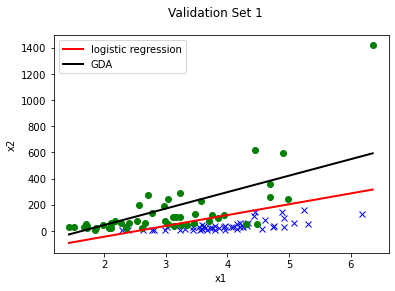

In [13]:
plot(x_valid, y_valid, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Validation Set 1')

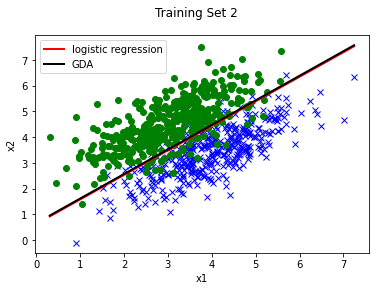

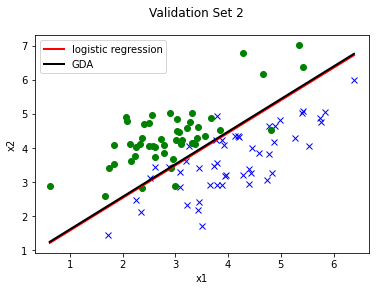

In [14]:
# Train logistic regression
x_train, y_train = util.load_dataset(ds2_training_set_path, add_intercept=True)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

# Train GDA
x_train, y_train = util.load_dataset(ds2_training_set_path)
gda = GDA()
gda.fit(x_train, y_train)

# Plot decision boundaries on training set 2
plot(x_train, y_train, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Training Set 2')

# Plot decision boundaries on validation set 2
x_valid, y_valid = util.load_dataset(ds2_valid_set_path)
plot(x_valid, y_valid, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Validation Set 2')

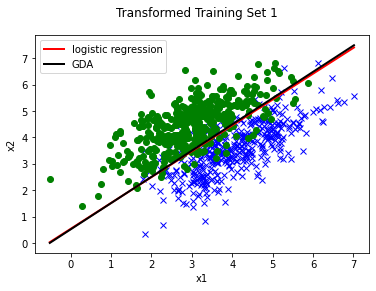

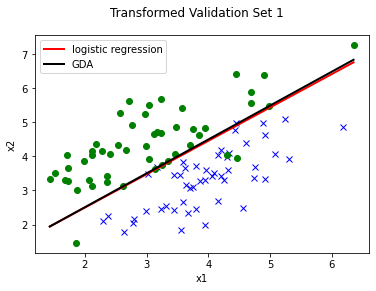

In [15]:
x_train, y_train = util.load_dataset(ds1_training_set_path)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path)
transformed_x_train = np.stack((x_train[:,0], np.log(x_train[:,1])), axis=1)
transformed_x_valid = np.stack((x_valid[:,0], np.log(x_valid[:,1])), axis=1)

# Train logistic regression
transformed_x_train_with_intercept = util.add_intercept(transformed_x_train)
log_reg = LogisticRegression()
log_reg.fit(transformed_x_train_with_intercept, y_train)

# Train GDA
gda = GDA()
gda.fit(transformed_x_train, y_train)

# Plot decision boundaries on training set 1
plot(transformed_x_train, y_train, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Transformed Training Set 1')

# Plot decision boundaries on validation set 1
plot(transformed_x_valid, y_valid, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Transformed Validation Set 1')

### <div style="text-align: left; background-color: #003554; color: white; padding: 10px; line-height: 1">PS1-2 Incomplete, Positive-Only Labels</div>
#### (a)
(a)
Suppose that each $y^{(i)}$ and $x^{(i)}$ are conditionally independent given $t^{(i)}$, that is
$$
p\left(y^{(i)}=1 \mid t^{(i)}=1, x^{(i)}\right)=p\left(y^{(i)}=1 \mid t^{(i)}=1\right)
$$
Then
$$
\begin{aligned}
p\left(y^{(i)} \mid x^{(i)}\right) &=\sum_{t^{(i)}} p\left(y^{(i)}=1, t^{(i)} \mid x^{(i)}\right) \\
&=p\left(y^{(i)}=1, t^{(i)}=1 \mid x^{(i)}\right)+p\left(y^{(i)}=1, t^{(i)}=0 \mid x^{(i)}\right) \\
&=p\left(y^{(i)}=1, t^{(i)}=1 \mid x^{(i)}\right)+0 \\
&=p\left(y^{(i)}=1 \mid t^{(i)}=1, x^{(i)}\right) p\left(t^{(i)}=1 \mid x^{(i)}\right) \\
&=p\left(y^{(i)}=1 \mid t^{(i)}=1\right) p\left(t^{(i)}=1 \mid x^{(i)}\right) \\
&=\alpha p\left(t^{(i)}=1 \mid x^{(i)}\right)
\end{aligned}
$$

Therefore, $p\left(t^{(i)}=1 \mid x^{(i)}\right)=p\left(y^{(i)} \mid x^{(i)}\right) / \alpha$, where $\alpha=p\left(y^{(i)}=1 \mid t^{(i)}=1\right)$.
(b)
$$
\begin{aligned}
h\left(x^{(i)}\right) & \approx p\left(y^{(i)}=1 \mid x^{(i)}\right) \\
&=\alpha p\left(t^{(i)}=1 \mid x^{(i)}\right) \\
& \approx \alpha \cdot 1 \\
&=\alpha
\end{aligned}
$$

In [16]:
x_train, y_train = util.load_dataset('ds3_train.csv', add_intercept=True)
_, t_train = util.load_dataset('ds3_train.csv', label_col='t')
x_valid, y_valid = util.load_dataset('ds3_valid.csv', add_intercept=True)
_, t_valid = util.load_dataset('ds3_valid.csv', label_col='t')
x_test, y_test = util.load_dataset('ds3_test.csv', add_intercept=True)
_, t_test = util.load_dataset('ds3_test.csv', label_col='t')

In [17]:
log_reg = LogisticRegression()
log_reg.fit(x_train, t_train)

Theta is:  [-0.9711418   2.73208784  1.07403478]
The accuracy on training set is:  0.9632


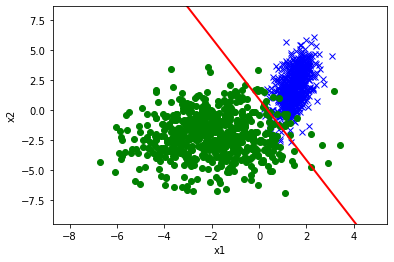

In [18]:
util.plot(x_train, t_train, log_reg.theta)
print("Theta is: ", log_reg.theta)
print("The accuracy on training set is: ", np.mean(t_train == log_reg.predict(x_train)))

Theta is:  [-0.9711418   2.73208784  1.07403478]
The accuracy on test set is:  0.9838709677419355


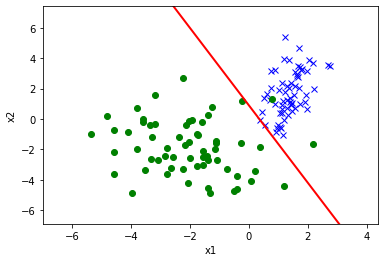

In [19]:
util.plot(x_test, t_test, log_reg.theta)
print("Theta is: ", log_reg.theta)
print("The accuracy on test set is: ", np.mean(t_test == log_reg.predict(x_test)))

In [20]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

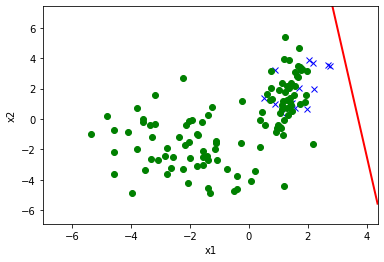

In [21]:
util.plot(x_test, y_test, log_reg.theta)

According to (b), we know that
$$
p\left(t^{(i)}=1 \mid x^{(i)}\right)=\frac{1}{\alpha} p\left(y^{(i)}=1 \mid x^{(i)}\right)
$$
meaning if we can find $\alpha$, we can estimate $p\left(t^{(i)}=1 \mid x^{(i)}\right)$ with y-labeled data.
It's easy to prove that $h\left(x^{(i)}\right)=\alpha$ when $y^{(i)}=1$, and $h\left(x^{(i)}\right)=0$ when $y^{(i)}=0$. Hence:
$$
\alpha=\mathbb{E}\left[h\left(x^{(i)}\right) \mid y^{(i)}=1\right] \approx \frac{1}{\left|V_{+}\right|} \sum_{x^{(i)} \in V_{+}} h\left(x^{(i)}\right)
$$
Reuse function $\mathrm{h}$ in the logistic regression model:

In [22]:
def h(theta, x):
    return 1 / (1 + np.exp(-np.dot(x, theta)))

In [23]:
v_plus = x_valid[y_valid == 1]
alpha = h(log_reg.theta, v_plus).mean()

In [24]:
def predict(theta, x):
    return h(theta, x) / alpha >= 0.5

To plot the decision boundary found by solving $\frac{1}{\alpha} \frac{1}{1+\exp \left(-\theta^{T} x\right)}=\frac{1}{2}$, we can equivalently transform the equation to the form of $\theta^{T} x=0$ and solve for $\theta^{\prime}$.\

By simplifying the equation, we obtain $\theta^{T} x+\log \left(\frac{2}{\alpha}-1\right)=0$. The left-hand side is in fact adding $\log \left(\frac{2}{\alpha}-1\right)$ to $\theta_{0}$. Hence, $\theta^{\prime}=\theta+\log \left(\frac{2}{\alpha}-1\right)[1,0,0]^{T}$.

In [25]:
theta_prime = log_reg.theta + np.log(2 / alpha - 1) * np.array([1, 0, 0])

Theta_prime is:  [-0.55096984  0.78596651  0.09282768]
The accuracy on test set is:  0.9516129032258065


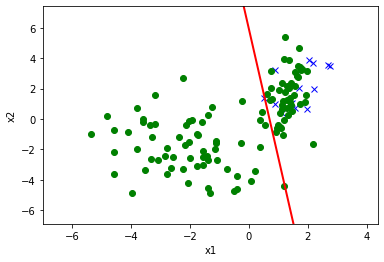

In [26]:
util.plot(x_test, y_test, theta_prime)
print("Theta_prime is: ", theta_prime)
print("The accuracy on test set is: ", np.mean(predict(log_reg.theta, x_test) == t_test))

### <div style="text-align: left; background-color: #003554; color: white; padding: 10px; line-height: 1">PS1-3 Poisson Regression <div>

In [27]:
x_train, y_train = util.load_dataset('ds4_train.csv', add_intercept=True)
x_valid, y_valid = util.load_dataset('ds4_valid.csv', add_intercept=True)

$$
\begin{aligned}
p(y ; \lambda) &=\frac{e^{-\lambda} \lambda^{y}}{y !} \\
&=\frac{1}{y !} \exp (y \log \lambda-\lambda) \\
&=b(y) \exp \left(\eta^{T} T(y)-a(\eta)\right)
\end{aligned}
$$
where $b(y)=\frac{1}{y !}, T(y)=y, \eta=\log \lambda$ and $a(\eta)=\exp (\eta)$.

(b)
$$
\begin{aligned}
\mathbb{E}[T(y) ; \eta] &=\mathbb{E}[y ; \eta] \\
&=\lambda \\
&=\exp (\eta)
\end{aligned}
$$
(c)
Recall the design choices of GLM:
1. $y \mid x ; \theta \sim \operatorname{ExponentialFamily}(\eta)$
2. $h(x)=\mathbb{E}[y \mid x]$
3. $\eta=\theta^{T} x$
Plug them into $\ell$ :
$$
\begin{aligned}
\ell(\theta) &=\log p\left(y^{(i)} \mid x^{(i)} ; \theta\right) \\
&=\log b\left(y^{(i)}\right) \exp \left(\eta^{T} T\left(y^{(i)}\right)-a\left(y^{(i)}\right)\right) \\
&=\left(x^{(i)}\right)^{T} \theta y^{(i)}-\exp \left(\theta^{T} x^{(i)}\right)-\log y^{(i)} !
\end{aligned}
$$
By design choice 2 and 3 :
$$
\begin{aligned}
h(x) &=\mathbb{E}[y \mid x] \\
&=\lambda \\
&=\exp (\eta) \\
&=\exp \left(\theta^{T} x\right)
\end{aligned}
$$
Therefore,
$$
\begin{aligned}
\frac{\partial}{\partial \theta} \ell(\theta) &=x^{(i)} y^{(i)}-x^{(i)} \exp \left(\theta^{T} x^{(i)}\right) \\
&=\left(y^{(i)}-h_{\theta}\left(x^{(i)}\right)\right) x^{(i)}
\end{aligned}
$$
The stochastic gradient ascent update rule is:
$$
\theta:=\theta+\alpha\left(y^{(i)}-h_{\theta}\left(x^{(i)}\right)\right) x^{(i)}
$$

In [28]:
class PoissonRegression(LinearModel):
    """Poisson Regression.

    Example usage:
        > clf = PoissonRegression(step_size=lr)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def h(self, theta, x):
        """Vectorized implementation of h.

        :param theta: Shape (n,).
        :param x:     Training example inputs. Shape (m, n).
        :return:      The hypothesis of Poisson Regression, given by h(x) = exp(theta^T x). Shape (m,).
        """
        return np.exp(x @ theta)

    def fit(self, x, y):
        """Run gradient ascent to maximize likelihood for Poisson regression.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """

        def next_step(theta):
            return self.step_size / m * x.T @ (y - self.h(theta, x))

        m, n = x.shape

        # Initialize theta
        if self.theta is None:
            theta = np.zeros(n)
        else:
            theta = self.theta

        # Update theta
        step = next_step(theta)
        while np.linalg.norm(step, 1) >= self.eps:
            theta += step
            step = next_step(theta)

        self.theta = theta

    def predict(self, x):
        """Make a prediction given inputs x.

        :param x: Inputs of shape (m, n).
        :return   Floating-point prediction for each input, shape (m,).
        """

        return self.h(self.theta, x)

In [29]:

clf = PoissonRegression(step_size=2e-7)
clf.fit(x_train, y_train)

In [30]:
def plot(y_label, y_pred, title):
    plt.plot(y_label, 'go', label='label')
    plt.plot(y_pred, 'rx', label='prediction')
    plt.suptitle(title, fontsize=12)
    plt.legend(loc='upper left')

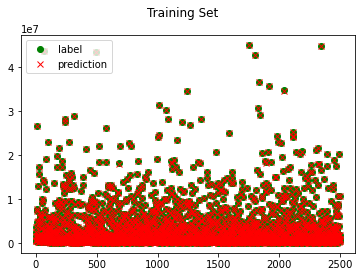

In [31]:
y_train_pred = clf.predict(x_train)
plot(y_train, y_train_pred, 'Training Set')

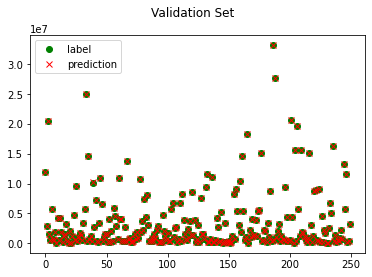

In [32]:
y_valid_pred = clf.predict(x_valid)
plot(y_valid, y_valid_pred, 'Validation Set')

### <div style="text-align: left; background-color: #003554; color: white; padding: 10px; line-height: 1">PS1-4 Convexity of Generalized Linear Model</div>

#### (a)
$$
\begin{aligned}
\frac{\partial}{\partial \eta} p(y ; \eta) &=\frac{\partial}{\partial \eta}(b(y) \exp (\eta y-a(\eta))) \\
&=b(y) \exp (\eta y-a(\eta))\left(y-\frac{\partial}{\partial \eta} a(\eta)\right) \\
&=y p(y ; \eta)-p(y ; \eta) \frac{\partial}{\partial \eta} a(\eta)
\end{aligned}
$$
which indicates:
$$
y p(y ; \eta)=\frac{\partial}{\partial \eta} p(y ; \eta)+p(y ; \eta) \frac{\partial}{\partial \eta} a(\eta)
$$
Therefore,
$$
\begin{aligned}
\mathbb{E}[Y ; \eta] &=\mathbb{E}[Y \mid X ; \eta] \\
&=\int y p(y ; \eta) d y \\
&=\int \frac{\partial}{\partial \eta} p(y ; \eta)+p(y ; \eta) \frac{\partial}{\partial \eta} a(\eta) d y \\
&=\int \frac{\partial}{\partial \eta} p(y ; \eta) d y+\int p(y ; \eta) \frac{\partial}{\partial \eta} a(\eta) d y \\
&=\frac{\partial}{\partial \eta} \int p(y ; \eta) d y+\frac{\partial}{\partial \eta} a(\eta) \int p(y ; \eta) d y \\
&=\frac{\partial}{\partial \eta} \cdot 1+\frac{\partial}{\partial \eta} a(\eta) \cdot 1 \\
&=0+\frac{\partial}{\partial \eta} a(\eta) \\
&=\frac{\partial}{\partial \eta} a(\eta)
\end{aligned}
$$
i.e. The mean of an exponential family distribution is the first derivative of the log-partition function w.r.t. the natural parameter.
#### (b)
Proof:
$$
\begin{aligned}
\frac{\partial^{2}}{\partial \eta^{2}} p(y ; \eta) &=\frac{\partial}{\partial \eta}\left(y p(y ; \eta)-p(y ; \eta) \frac{\partial}{\partial \eta} a(\eta)\right) \\
&=p(y ; \eta)+y^{2} p(y ; \eta)-2 y p(y ; \eta) \frac{\partial}{\partial \eta} a(\eta)+p(y ; \eta)\left(\frac{\partial}{\partial \eta} a(\eta)\right)^{2}-p(y ; \eta) \frac{\partial^{2}}{\partial \eta^{2}} a(\eta) \\
&=p(y ; \eta)-p(y ; \eta) \frac{\partial^{2}}{\partial \eta^{2}} a(\eta)+\left(y-\frac{\partial}{\partial \eta} a(\eta)\right)^{2} p(y ; \eta)
\end{aligned}
$$
which implies:
$$
\left(y-\frac{\partial}{\partial \eta} a(\eta)\right)^{2} p(y ; \eta)=\frac{\partial^{2}}{\partial \eta^{2}} p(y ; \eta)-p(y ; \eta)+p(y ; \eta) \frac{\partial^{2}}{\partial \eta^{2}} a(\eta)
$$
Hence,
$$
\begin{aligned}
\operatorname{Var}[Y ; \eta] &=\int(y-\mathbb{E}[Y ; \eta])^{2} p(y ; \eta) d y \\
&=\int\left(y-\frac{\partial}{\partial \eta} a(\eta)\right)^{2} p(y ; \eta) d y \\
&=\int \frac{\partial^{2}}{\partial \eta^{2}} p(y ; \eta)-p(y ; \eta)+p(y ; \eta) \frac{\partial^{2}}{\partial \eta^{2}} a(\eta) d y \\
&=\int \frac{\partial^{2}}{\partial \eta^{2}} p(y ; \eta) d y-\int p(y ; \eta) d y+\int p(y ; \eta) \frac{\partial^{2}}{\partial \eta^{2}} a(\eta) d y \\
&=\frac{\partial^{2}}{\partial \eta^{2}} \int p(y ; \eta) d y-\int p(y ; \eta) d y+\frac{\partial^{2}}{\partial \eta^{2}} a(\eta) \int p(y ; \eta) d y \\
&=1-1+\frac{\partial^{2}}{\partial \eta^{2}} a(\eta) \\
&=\frac{\partial^{2}}{\partial \eta^{2}} a(\eta)
\end{aligned}
$$
i.e. The variance of an exponential family distribution is the second derivative of the log-partition function w.r.t. the natural parameter.

#### (c)
#### Recall the NLL
$$
\begin{aligned}
\ell(\theta) &=-\log p\left(y^{(i)} ; \eta\right) \\
&=-\log b\left(y^{(i)}\right) \exp \left(\eta^{T} T\left(y^{(i)}\right)-a(\eta)\right) \\
&=a(\eta)-\eta^{T} y^{(i)}-\log b\left(y^{(i)}\right) \\
&=a\left(\theta^{T} x\right)-x^{T} \theta y-\log b(y)
\end{aligned}
$$
We can easily compute the gradient of $\ell$
$$
\nabla_{\theta} \ell(\theta)=x \frac{\partial}{\partial \theta} a\left(\theta^{T} x\right)-y x
$$
So the Hessian of $\ell$ is
$$
H=\nabla_{\theta}^{2} \ell(\theta)=x x^{T} \frac{\partial^{2}}{\partial \theta^{2}} a\left(\theta^{T} x\right)
$$
For any $z \in \mathbb{R}^{n}$, we have
$$
\begin{aligned}
z^{T} H z &=z^{T}\left(x x^{T} \frac{\partial^{2}}{\partial \theta^{2}} a\left(\theta^{T} x\right)\right) z \\
&=z^{T} x x^{T} z \frac{\partial^{2}}{\partial \theta^{2}} a\left(\theta^{T} x\right) \\
&=\left(x^{T} z\right)^{2} \frac{\partial^{2}}{\partial \theta^{2}} a(\eta) \\
&=\left(x^{T} z\right)^{2} \operatorname{Var}[Y ; \eta] \\
& \geq 0
\end{aligned}
$$
which means the Hessian is PSD, showing that the NLL loss of GLM is convex.

### <div style="text-align: left; background-color: #003554; color: white; padding: 10px; line-height: 1">PS1-5 Locally Weighted Linear Regression</div>

#### (a)
i.
Recall the cost function
$$
\begin{aligned}
J(\theta) &=\frac{1}{2} \sum_{i=1}^{m} w^{(i)}\left(\theta^{T} x^{(i)}-y^{(i)}\right)^{2} \\
&=(X \theta-y)^{T} W(X \theta-y)
\end{aligned}
$$
Notice that there are only $m w^{(i)}$ 's, and $w^{(i)}$ only takes effect on the $i$-th entry of $(X \theta-y)^{T}$ and $(X \theta-y)$. Hence, $W$ is a diagonal matrix, and the above equation holds by picking:
$$
X=\left[\begin{array}{c}
-\left(x^{(1)}\right)^{T}- \\
\vdots \\
-\left(x^{(m)}\right)^{T}-
\end{array}\right] \in \mathbb{R}^{m \times n} \quad y=\left[\begin{array}{c}
y^{(1)} \\
\vdots \\
y^{(m)}
\end{array}\right] \quad W=\frac{1}{2} \operatorname{diag}\left(w^{(i)}, \ldots, w^{(m)}\right)
$$
ii.
To simplify the calculation, let $J(\theta)=\frac{1}{2}(X \theta-y)^{T} W(X \theta-y)$. To minimize $J$, take derivative w.r.t $\theta$ and set to 0 :
$$
\begin{aligned}
\nabla_{\theta} J(\theta) &=\nabla_{\theta}\left(\frac{1}{2}(X \theta-y)^{T} W(X \theta-y)\right) \\
&=\frac{1}{2} \nabla_{\theta}\left(\theta^{T} X^{T} W X \theta-2 y^{T} W X \theta+y^{T} U\right.\\
&=\frac{1}{2} \nabla_{\theta}\left(\theta^{T}\left(X^{T} W X\right) \theta-2\left(X^{T} W^{T} y\right)^{T} \theta\right.\\
&=\frac{1}{2}\left(2 X^{T} W X \theta-2 X^{T} W^{T} y\right) \\
&=X^{T} W X \theta-X^{T} W^{T} y \\
&=X^{T} W X \theta-X^{T} W y \\
&=0
\end{aligned}
$$
By solving the equation, we obtain:
$$
\theta=\left(X^{T} W X\right)^{-1} X^{T} W y
$$
iii.
$$
\begin{aligned}
\ell(\theta) &=\sum_{i=1}^{m} \log \frac{1}{\sqrt{2 \pi} \sigma^{(i)}} \exp \left(-\frac{\left(y^{(i)}-\theta^{T} x^{(i)}\right)^{2}}{2\left(\sigma^{(i)}\right)^{2}}\right) \\
&=-m \log \sqrt{2 \pi} \sigma^{(i)}-\sum_{i=1}^{m} \frac{\left(y^{(i)}-\theta^{T} x^{(i)}\right)^{2}}{2\left(\sigma^{(i)}\right)^{2}} \\
&=-\frac{1}{2} \sum_{i=1}^{m} \frac{1}{\left(\sigma^{(i)}\right)^{2}}\left(\theta^{T} x^{(i)}-y^{(i)}\right)^{2}-m \log \sqrt{2 \pi} \sigma^{(i)}
\end{aligned}
$$
Thus, maximizing $\ell(\theta)$ is equivalent to minimizing
$$
\frac{1}{2} \sum_{i=1}^{m} \frac{1}{\left(\sigma^{(i)}\right)^{2}}\left(\theta^{T} x^{(i)}-y^{(i)}\right)^{2}
$$
By setting $w^{(i)}=1 /\left(\sigma^{(i)}\right)^{2}$, finding the maximum likelihood estimate of $\theta$ reduces to minimizing $J(\theta)$.
(b)

In [33]:
import math

In [34]:
x_train, y_train = util.load_dataset('ds5_train.csv', add_intercept=True)
x_valid, y_valid = util.load_dataset('ds5_valid.csv', add_intercept=True)
x_test, y_test = util.load_dataset('ds5_test.csv', add_intercept=True)

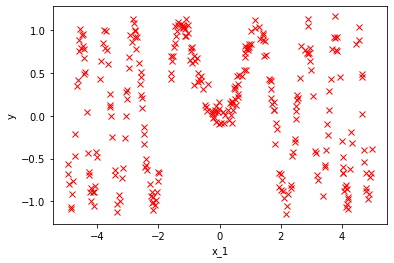

In [35]:
plt.xlabel('x_1')
plt.ylabel('y')
plt.plot(x_train[:,-1], y_train, 'rx', linewidth=2)

In [36]:
class LocallyWeightedLinearRegression(LinearModel):
    """Locally Weighted Regression (LWR).

    Example usage:
        > clf = LocallyWeightedLinearRegression(tau)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """

        self.x = x
        self.y = y

    def predict(self, x):
        """Make predictions given inputs x.

        :param x: Inputs of shape (l, n).
        :return:  Outputs of shape (l,).
        """

        l, n = x.shape

        # Reshape the input x by adding an additional dimension so that it can broadcast
        w_vector = np.exp(- np.linalg.norm(self.x - np.reshape(x, (l, -1, n)), ord=2, axis=2)**2 / (2 * self.tau**2))

        # Turn the weights into diagonal matrices, each corresponds to a single input. Shape (l, m, m)
        w = np.apply_along_axis(np.diag, axis=1, arr=w_vector)

        # Compute theta for each input x^(i). Shape (l, n)
        theta = np.linalg.inv(self.x.T @ w @ self.x) @ self.x.T @ w @ self.y

        return np.einsum('ij,ij->i', x, theta)

In [37]:
clf = LocallyWeightedLinearRegression(tau=0.5)
clf.fit(x_train, y_train)

In [38]:
def plot(x, y_label, y_pred, title):
    plt.figure()
    plt.plot(x[:,-1], y_label, 'rx', label='label')
    plt.plot(x[:,-1], y_pred, 'bo', label='prediction')
    plt.suptitle(title, fontsize=12)
    plt.legend(loc='upper left')

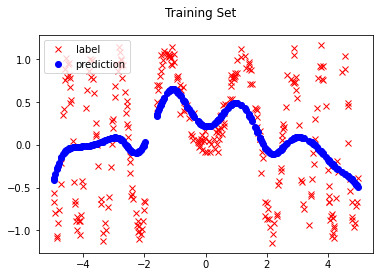

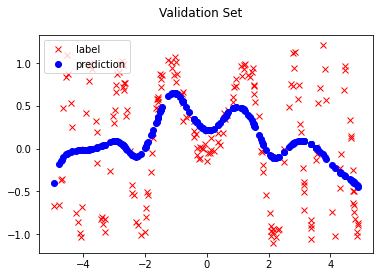

In [39]:
y_train_pred = clf.predict(x_train)
plot(x_train, y_train, y_train_pred, 'Training Set')

y_valid_pred = clf.predict(x_valid)
plot(x_valid, y_valid, y_valid_pred, 'Validation Set')

Tau = 0.05 achieves the lowest MSE on the validation set.


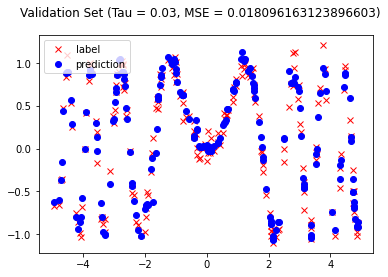

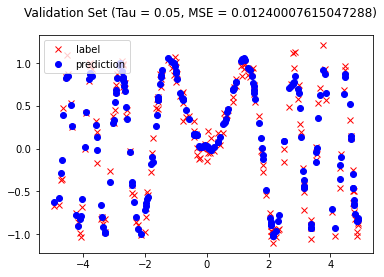

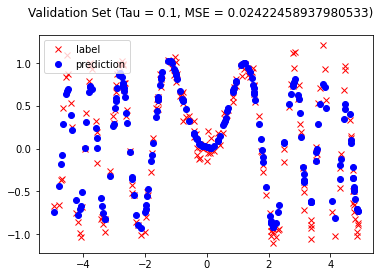

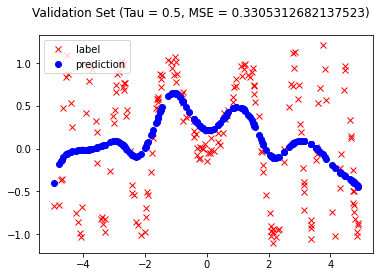

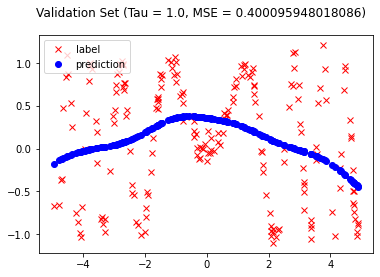

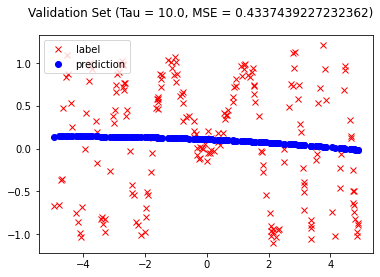

In [40]:
taus = [3e-2, 5e-2, 1e-1, 5e-1, 1e0, 1e1]

lowest_mse = math.inf
best_tau = taus[0]

for tau in taus:
    clf = LocallyWeightedLinearRegression(tau)
    clf.fit(x_train, y_train)
    y_valid_pred = clf.predict(x_valid)

    mse = np.mean((y_valid_pred - y_valid)**2)
    if mse < lowest_mse:
        lowest_mse = mse
        best_tau = tau

    plot(x_valid, y_valid, y_valid_pred, f'Validation Set (Tau = {tau}, MSE = {mse})')

print(f'Tau = {best_tau} achieves the lowest MSE on the validation set.')

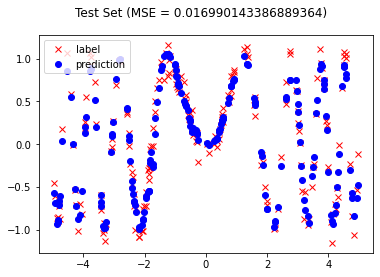

In [41]:
clf = LocallyWeightedLinearRegression(tau=0.05)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)
plot(x_test, y_test, y_test_pred, f'Test Set (MSE = {np.mean((y_test_pred - y_test)**2)})')
